In [1]:
!pip install lightning
!pip install torch torchvision torchaudio


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/fb/73/861afa5864e95fbf42b693e0359b2bf0177b6b5f4274fa4472fd51e5298e/torchaudio-2.6.0-cp313-cp313-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [47]:
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics
from torchvision import transforms
from torchvision.datasets import Imagenette
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [48]:
class BasicCNN(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.save_hyperparameters()

        self.train_losses = []
        self.val_losses = []

        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4)),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        self.accuracy = torchmetrics.classification.MulticlassAccuracy(num_classes=num_classes)

    def forward(self, x):
        x = self.cnn(x)
        print(x.shape)
        x = x.view(x.shape[0], -1)  # Flatten the tensor
        return self.classifier(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def on_train_epoch_end(self):
        # Access average training loss
        train_loss = self.trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        val_loss = self.trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.val_losses.append(val_loss.item())

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracy(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_accuracy", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [49]:
# Transforms for grayscale and normalization
train_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [50]:
# Load datasets
train_dataset = Imagenette("data/imagenette/train/", split="train", size="160px", download=True, transform=train_transforms)
test_dataset = Imagenette("data/imagenette/test/", split="val", size="160px", download=True, transform=test_transforms)

In [51]:
# Split train/val
train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size
seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = test_transforms

In [52]:
# Dataloaders
BATCH_SIZE = 256

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, persistent_workers=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, persistent_workers=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, persistent_workers=True)

In [53]:
# Model
model = BasicCNN(num_classes=10)

# Callbacks
early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min")
checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)

# Trainer
trainer = L.Trainer(
    max_epochs=30,
    callbacks=[early_stop_callback, checkpoint_callback],
    accelerator="auto"
)

# Train and test
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
trainer.test(model, dataloaders=test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | cnn        | Sequential         | 371 K  | train
1 | classifier | Sequential         | 527 K  | train
2 | accuracy   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
898 K     Trainable params
0         Non-trainable params
898 K     Total params
3.595     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]torch.Size([256, 256, 4, 4])


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (256x4096 and 2048x256)

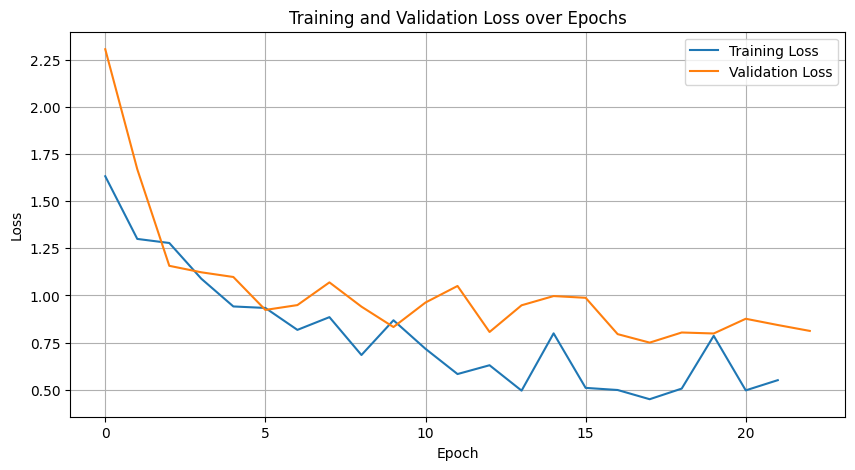

In [46]:
import matplotlib.pyplot as plt

def plot_losses(model):
    plt.figure(figsize=(10, 5))
    plt.plot(model.train_losses, label="Training Loss")
    plt.plot(model.val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call this after training
plot_losses(model)
